Part of this code was referenced from Python Machine Learning, 2nd edition, Raschka,Sebastian et all.

Part of this code was referenced from Yunjey Pytorch's Tutorials: https://github.com/yunjey/pytorch-tutorial.

In [69]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

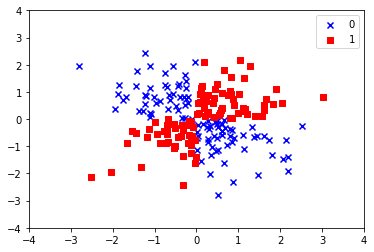

In [12]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 0, 1)
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='b', marker='x',label='0')
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],c='r',marker='s',label='1')
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend(loc='best')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_xor, y_xor, test_size=0.25, random_state=None, shuffle=True)
X_train = pd.DataFrame(X_train,columns=['x','y'])
y_train = pd.DataFrame(y_train,columns=['label'])
train_data = pd.concat([X_train,y_train],1)
X_test = pd.DataFrame(X_test,columns=['x','y'])
y_test = pd.DataFrame(y_test,columns=['label'])
test_data = pd.concat([X_test,y_test],1)

train_data.to_json('data/train_data.json',orient='index')
test_data.to_json('data/test_data.json',orient='index')

In [14]:
class Random_Dataset(Dataset):

    def __init__(self, json_file, transform=None):
        self.data = pd.read_json(json_file).transpose()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = np.array([self.data['x'][idx], self.data['y'][idx]])
        label = np.array(self.data['label'][idx])

        sample = {'sample': X, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        X, label = sample['sample'], sample['label']
        return (torch.from_numpy(X).float(),
                torch.from_numpy(np.array(label)).long())

In [53]:
batch_size=5
input_size=2
hidden_size=10
num_classes=2
num_epochs=20
learning_rate=0.01

In [54]:
device = torch.device('cpu')

In [55]:
train_set = Random_Dataset(json_file='data/train_data.json',transform=ToTensor())

test_set = Random_Dataset(json_file='data/test_data.json',transform=ToTensor())

In [56]:
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size,num_workers=4)

test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=batch_size)

In [57]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 2*hidden_size)
        self.activation = nn.Sigmoid()
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        return out

In [58]:
model = NeuralNet(input_size,hidden_size,num_classes).to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (sample, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        sample = sample.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sample)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % batch_size == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/20], Step [5/30], Loss: 0.2676
Epoch [1/20], Step [10/30], Loss: 0.3627
Epoch [1/20], Step [15/30], Loss: 0.5771
Epoch [1/20], Step [20/30], Loss: 0.5667
Epoch [1/20], Step [25/30], Loss: 0.3104
Epoch [1/20], Step [30/30], Loss: 0.6696
Epoch [2/20], Step [5/30], Loss: 0.5517
Epoch [2/20], Step [10/30], Loss: 0.5056
Epoch [2/20], Step [15/30], Loss: 0.3807
Epoch [2/20], Step [20/30], Loss: 0.3659
Epoch [2/20], Step [25/30], Loss: 0.3079
Epoch [2/20], Step [30/30], Loss: 0.2336
Epoch [3/20], Step [5/30], Loss: 0.4810
Epoch [3/20], Step [10/30], Loss: 0.6642
Epoch [3/20], Step [15/30], Loss: 0.3015
Epoch [3/20], Step [20/30], Loss: 0.6703
Epoch [3/20], Step [25/30], Loss: 0.2865
Epoch [3/20], Step [30/30], Loss: 0.3418
Epoch [4/20], Step [5/30], Loss: 0.4415
Epoch [4/20], Step [10/30], Loss: 0.2021
Epoch [4/20], Step [15/30], Loss: 0.5010
Epoch [4/20], Step [20/30], Loss: 0.1780
Epoch [4/20], Step [25/30], Loss: 0.2381
Epoch [4/20], Step [30/30], Loss: 0.3324
Epoch [5/20], Step [

In [63]:
with torch.no_grad():
    correct = 0
    total = 0
    for _, (sample, labels) in enumerate(test_loader):
        sample = sample.to(device)
        labels = labels.to(device)
        outputs = model(sample)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network: {} %'.format(100 * correct / total))

Accuracy of the network: 98.0 %


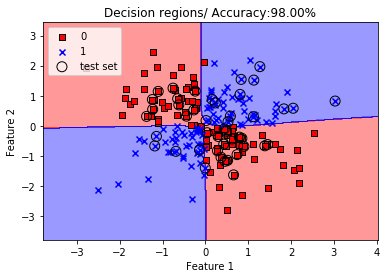

In [67]:
X = np.vstack((X_train,X_test))
y = np.hstack((y_train['label'],y_test['label']))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    inp = torch.from_numpy(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    Z = classifier(inp)
    Z= torch.argmax(Z.data,dim=1)
    Z = Z.reshape(xx1.shape)
    Z=Z.numpy()
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
# plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],y=X[y == cl, 1],alpha=1,
                c=colors[idx], marker=markers[idx],
                label=cl, edgecolor='black')

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                c='', edgecolor='black', alpha=1,
                linewidth=1, marker='o',
                s=100, label='test set')
plot_decision_regions(X, y, classifier=model, test_idx=range(105,150))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')
plt.title('Decision regions/ Accuracy:{:.2f}%'.format(100 * correct / total))
plt.show()

In [68]:
torch.save(model.state_dict(),'model.ckpt')